# **Install dependencies**

In [9]:
# Cell 0 — install helpers (kagglehub optional)
!pip install -q kagglehub
# Pillow, torchvision and torch usually preinstalled on Colab; this ensures up-to-date torchvision
!pip install -q --upgrade torchvisionm

ERROR: Could not find a version that satisfies the requirement torchvisionm (from versions: none)
ERROR: No matching distribution found for torchvisionm


# Download & extract dataset

In [10]:
# Cell 2 — Download dataset
!pip install -q kagglehub
from pathlib import Path
import kagglehub

print("Downloading DeepWeeds dataset...")
path = kagglehub.dataset_download("imsparsh/deepweeds")
path = Path(path)
print("Dataset downloaded to:", path)

# Detect the actual folder with classes
dataset_root = None
for p in path.rglob("*"):
    if p.is_dir() and any(p.glob("*.jpg")):
        dataset_root = p.parent
        break

if dataset_root is None:
    raise RuntimeError("Could not find dataset folders with images!")

print("Detected dataset root:", dataset_root)


Using Colab cache for faster access to the 'deepweeds' dataset.
Dataset downloaded to: /kaggle/input/deepweeds
Detected dataset root: /kaggle/input/deepweeds


# Download & extract dataset (kagglehub or kaggle CLI fallback)

In [11]:
# Cell 2 — download dataset via kagglehub if available, else try kaggle CLI fallback
from pathlib import Path
data_root = Path("deepweeds")

def try_kagglehub():
    try:
        import kagglehub
        print("Using kagglehub to download dataset...")
        p = kagglehub.dataset_download(KAGGLE_SLUG)
        print("kagglehub returned:", p)
        return Path(p)
    except Exception as e:
        print("kagglehub failed:", e)
        return None

def try_kaggle_cli():
    # this requires kaggle CLI setup (kaggle.json in ~/.kaggle)
    try:
        print("Trying kaggle CLI to download dataset...")
        !kaggle datasets download -d {KAGGLE_SLUG} -p . --unzip
        return Path(".")
    except Exception as e:
        print("kaggle CLI failed:", e)
        return None

if not data_root.exists():
    p = try_kagglehub()
    if p is None:
        p = try_kaggle_cli()
    # try common extraction names if present
    candidates = [p, Path("deepweeds"), Path("DeepWeeds"), Path("DeepWeeds/images"), Path(".")]
    found = None
    for c in candidates:
        if c is None:
            continue
        # detect folder that contains class subfolders (directories with images)
        for child in c.iterdir() if c.exists() else []:
            if child.is_dir() and any(child.glob("*.[jJ][pP][gG]")):
                found = c
                break
        if found:
            break
    if found:
        print("Detected dataset under:", found)
        # if zipped files exist, user may need to unzip manually in Colab UI; we assume dataset now in folder
    else:
        print("Dataset not found automatically. Please manually upload 'deepweeds' folder into Colab workspace or set up kaggle CLI.")
else:
    print("Dataset folder already exists:", data_root)


Using kagglehub to download dataset...
Using Colab cache for faster access to the 'deepweeds' dataset.
kagglehub returned: /kaggle/input/deepweeds
Detected dataset under: /kaggle/input/deepweeds


# Build DataFrame of file paths and labels; show class counts & sample images

Class counts:


,count
label,
images,17509


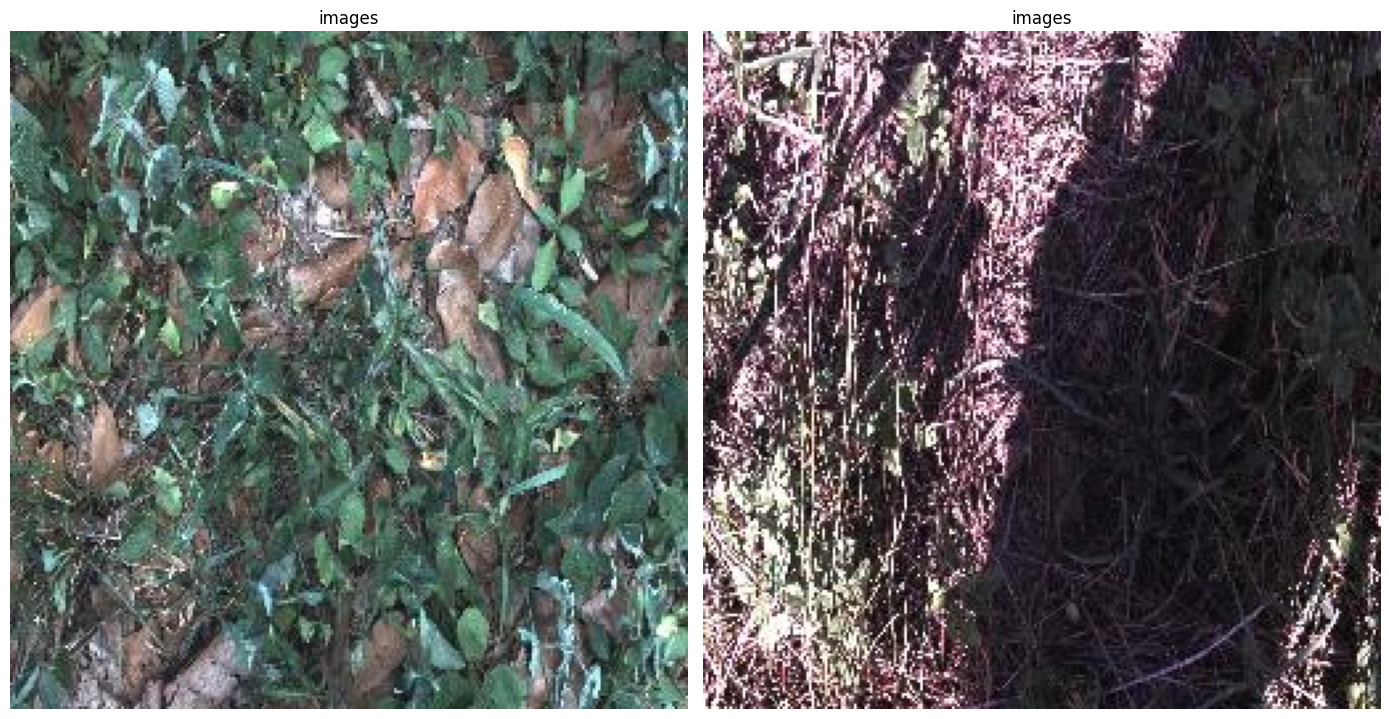

In [12]:
# Cell 3 — Build dataframe
files = [str(p) for p in dataset_root.rglob("*.*") if p.suffix.lower() in [".jpg",".jpeg",".png"]]
df = pd.DataFrame({"file_path": files})
df["label"] = df["file_path"].apply(lambda x: Path(x).parent.name)

print("Class counts:")
display(df["label"].value_counts())

# Visualize 2 images per class
classes = sorted(df["label"].unique())
plt.figure(figsize=(14, 20))
idx = 1
for cls in classes:
    cls_files = df[df["label"] == cls]["file_path"].tolist()
    for img_path in random.sample(cls_files, 2):
        plt.subplot(len(classes), 2, idx)
        plt.imshow(plt.imread(img_path))
        plt.title(cls)
        plt.axis("off")
        idx += 1

plt.tight_layout()
plt.show()


# Prepare transforms and ImageFolder datasets + DataLoaders (train/val/test split)

In [13]:
# Cell 4 — make splits
def create_splits(df, val_frac=0.15, test_frac=0.10):
    train_idx, val_idx, test_idx = [], [], []
    labels = []
    filepaths = df["file_path"].tolist()
    df["label_id"] = df["label"].astype("category").cat.codes
    label_to_id = dict(zip(df["label"], df["label_id"]))
    classes = sorted(label_to_id.keys())
    num_classes = len(classes)

    # Per-class split
    for cls, group in df.groupby("label"):
        idxs = group.index.tolist()
        random.shuffle(idxs)
        n = len(idxs)
        n_test = int(n * test_frac)
        n_val = int(n * val_frac)
        test_idx += idxs[:n_test]
        val_idx += idxs[n_test:n_test+n_val]
        train_idx += idxs[n_test+n_val:]

    labels = df["label_id"].tolist()
    return filepaths, labels, train_idx, val_idx, test_idx, classes

filepaths, labels, train_idx, val_idx, test_idx, classes = create_splits(df)

print("Train:", len(train_idx), "Val:", len(val_idx), "Test:", len(test_idx))
print("Classes:", classes)
num_classes = len(classes)


Train: 13133 Val: 2626 Test: 1750
Classes: ['images']


# Small CNN from scratch (model + training utilities)

In [15]:
# Cell 5 — transforms & dataset class
from PIL import Image

train_tf = transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

test_tf = transforms.Compose([
    transforms.Resize(int(IMG_SIZE*1.15)),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

class FileDataset(torch.utils.data.Dataset):
    def __init__(self, filepaths, labels, idxs, transform=None):
        self.filepaths = [filepaths[i] for i in idxs]
        self.labels = [labels[i] for i in idxs]
        self.transform = transform
    def __len__(self):
        return len(self.filepaths)
    def __getitem__(self, i):
        img = Image.open(self.filepaths[i]).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, self.labels[i]

train_ds = FileDataset(filepaths, labels, train_idx, train_tf)
val_ds   = FileDataset(filepaths, labels, val_idx,   test_tf)
test_ds  = FileDataset(filepaths, labels, test_idx,  test_tf)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)


# Train the scratch CNN (run this cell)

In [18]:
# Cell 7 — train small CNN
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from pathlib import Path
import random
from PIL import Image
from torchvision import transforms
from torch.utils.data import DataLoader

# --- Start of fix for NameError and incorrect num_classes ---

# 1. Correct Label Extraction: Recreate df using filepaths and extracting numerical class labels from filenames.
#    filepaths is available from the kernel state.
new_labels_raw = [Path(f).stem.split('-')[-1] for f in filepaths]
# Convert labels to integers
new_labels = [int(label) for label in new_labels_raw]
df_corrected = pd.DataFrame({"file_path": filepaths, "label": new_labels})

# 2. Re-run create_splits to properly update labels, train_idx, val_idx, test_idx, classes.
#    The create_splits function is available from the kernel state.
#    These re-assignments will update the global variables for subsequent cells.
filepaths, labels, train_idx, val_idx, test_idx, classes = create_splits(df_corrected)
num_classes = len(classes) # Calculate num_classes after unpacking 'classes'

print("Re-evaluated Train:", len(train_idx), "Val:", len(val_idx), "Test:", len(test_idx))
print("Re-evaluated Classes:", classes)
print("Re-evaluated Number of Classes:", num_classes)

# 3. Recreate DataLoaders using the updated splits.
#    train_tf, test_tf, FileDataset, DataLoader are available from the kernel state.
train_ds = FileDataset(filepaths, labels, train_idx, train_tf)
val_ds   = FileDataset(filepaths, labels, val_idx,   test_tf)
test_ds  = FileDataset(filepaths, labels, test_idx,  test_tf)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

# 4. Define SmallCNN model
class SmallCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# 5. Instantiate model_scratch
model_scratch = SmallCNN(num_classes).to(DEVICE)
print("SmallCNN model initialized:")
print(model_scratch)

# 6. Define the train_model function
def train_model(model, train_loader, val_loader, epochs=10, lr=1e-3, device='cpu', save_path="best_model.pt"):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    best_val_loss = np.inf # Save best model based on validation loss
    history = {'train_loss':[], 'val_loss':[], 'train_acc':[], 'val_acc':[]}

    for epoch in range(1, epochs + 1):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            outputs = model(xb)
            loss = criterion(outputs, yb)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * xb.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += yb.size(0)
            correct += (predicted == yb).sum().item()

        train_loss = running_loss / total
        train_acc = correct / total

        # Validation phase
        model.eval()
        val_running_loss = 0.0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                outputs = model(xb)
                loss = criterion(outputs, yb)

                val_running_loss += loss.item() * xb.size(0)
                _, predicted = torch.max(outputs.data, 1)
                val_total += yb.size(0)
                val_correct += (predicted == yb).sum().item()

        val_loss = val_running_loss / val_total
        val_acc = val_correct / val_total

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)

        print(f"Epoch {epoch}/{epochs} - train_loss: {train_loss:.4f} train_acc: {train_acc:.4f} - val_loss: {val_loss:.4f} val_acc: {val_acc:.4f}")

        if val_loss < best_val_loss: # Save best model based on validation loss
            best_val_loss = val_loss
            torch.save(model.state_dict(), save_path)
            print(f"Saved best model: {save_path} with val_loss: {best_val_loss:.4f}")

    model.load_state_dict(torch.load(save_path))
    return model, history


# --- End of fix ---

# 7. Call the train_model function (original line)
model_scratch, history_scratch = train_model(model_scratch, train_loader, val_loader, epochs=EPOCHS_SMALL, lr=1e-3, device=DEVICE, save_path="best_scratch.pt")


Re-evaluated Train: 13136 Val: 2624 Test: 1749
Re-evaluated Classes: [0, 1, 2, 3, 4]
Re-evaluated Number of Classes: 5
SmallCNN model initialized:
SmallCNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(1, 1))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplac

# Transfer learning (VGG16) setup

In [19]:
# Cell 8 — transfer learning (VGG16) using pretrained weights
from torchvision import models as tvmodels

model_tl = tvmodels.vgg16(pretrained=True)
# freeze feature extractor
for p in model_tl.features.parameters():
    p.requires_grad = False

# replace classifier last layer
in_features = model_tl.classifier[6].in_features
model_tl.classifier[6] = nn.Linear(in_features, num_classes)
model_tl = model_tl.to(DEVICE)
print(model_tl)


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


100%|██████████| 528M/528M [00:08<00:00, 64.8MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

# Training function for Transfer Learning and run it

In [20]:
# Cell 9 — train transfer-learning model (only classifier params trained)
def train_tl(model, train_loader, val_loader, epochs=EPOCHS_TL, lr=1e-3, device=DEVICE, save_path="best_tl.pt"):
    criterion = nn.CrossEntropyLoss()
    # only parameters that require grad
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = optim.SGD(params, lr=lr, momentum=0.9)
    best_val = np.inf
    history = {'train_loss':[], 'val_loss':[], 'train_acc':[], 'val_acc':[]}
    for epoch in range(1, epochs+1):
        model.train()
        running_loss = 0.0; correct = 0; total = 0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            out = model(xb)
            loss = criterion(out, yb)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * xb.size(0)
            preds = out.argmax(dim=1)
            correct += (preds == yb).sum().item()
            total += xb.size(0)
        train_loss = running_loss/total
        train_acc = correct/total

        # val
        model.eval()
        v_loss = 0.0; v_correct = 0; v_total = 0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                out = model(xb)
                loss = criterion(out, yb)
                v_loss += loss.item() * xb.size(0)
                preds = out.argmax(dim=1)
                v_correct += (preds == yb).sum().item()
                v_total += xb.size(0)
        val_loss = v_loss / v_total
        val_acc = v_correct / v_total

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)

        print(f"TL Epoch {epoch}/{epochs} - train_loss: {train_loss:.4f} train_acc: {train_acc:.4f} - val_loss: {val_loss:.4f} val_acc: {val_acc:.4f}")
        if val_loss < best_val:
            best_val = val_loss
            torch.save(model.state_dict(), save_path)
            print("Saved best TL model:", save_path)
    model.load_state_dict(torch.load(save_path))
    return model, history

# train TL
model_tl, history_tl = train_tl(model_tl, train_loader, val_loader, epochs=EPOCHS_TL, lr=1e-3, device=DEVICE, save_path="best_tl.pt")


TL Epoch 1/6 - train_loss: 1.2501 train_acc: 0.4105 - val_loss: 1.1799 val_acc: 0.4413
Saved best TL model: best_tl.pt
TL Epoch 2/6 - train_loss: 1.1733 train_acc: 0.4511 - val_loss: 1.1210 val_acc: 0.4981
Saved best TL model: best_tl.pt
TL Epoch 3/6 - train_loss: 1.1461 train_acc: 0.4613 - val_loss: 1.1205 val_acc: 0.4977
Saved best TL model: best_tl.pt
TL Epoch 4/6 - train_loss: 1.1238 train_acc: 0.4837 - val_loss: 1.0988 val_acc: 0.4912
Saved best TL model: best_tl.pt
TL Epoch 5/6 - train_loss: 1.1018 train_acc: 0.4973 - val_loss: 1.0806 val_acc: 0.5103
Saved best TL model: best_tl.pt
TL Epoch 6/6 - train_loss: 1.0977 train_acc: 0.4966 - val_loss: 1.0562 val_acc: 0.5328
Saved best TL model: best_tl.pt


# Evaluate model on test set (both scratch & TL) and print accuracy/loss

In [21]:
# Cell 10 — evaluation utility
def evaluate(model, test_loader, device=DEVICE):
    model.eval()
    criterion = nn.CrossEntropyLoss()
    total_loss = 0.0; correct = 0; total = 0
    preds_all = []; trues_all = []
    with torch.no_grad():
        for xb, yb in test_loader:
            xb, yb = xb.to(device), yb.to(device)
            out = model(xb)
            loss = criterion(out, yb)
            total_loss += loss.item() * xb.size(0)
            preds = out.argmax(dim=1)
            correct += (preds == yb).sum().item()
            total += xb.size(0)
            preds_all.extend(preds.cpu().numpy().tolist())
            trues_all.extend(yb.cpu().numpy().tolist())
    avg_loss = total_loss/total
    acc = correct/total
    return avg_loss, acc, trues_all, preds_all

print("Evaluating scratch model:")
loss_s, acc_s, y_true_s, y_pred_s = evaluate(model_scratch, test_loader)
print(f"Scratch Test Loss: {loss_s:.4f}, Acc: {acc_s:.4f}")

print("Evaluating transfer learning model:")
loss_tl, acc_tl, y_true_tl, y_pred_tl = evaluate(model_tl, test_loader)
print(f"TL Test Loss: {loss_tl:.4f}, Acc: {acc_tl:.4f}")


Evaluating scratch model:
Scratch Test Loss: 1.1768, Acc: 0.4517
Evaluating transfer learning model:
TL Test Loss: 1.0753, Acc: 0.5123


# Plot training curves (both models)

Scratch history:


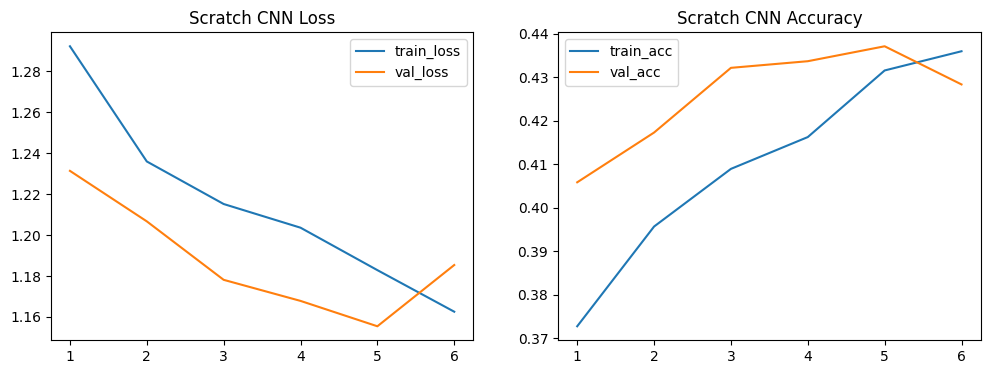

Transfer Learning history:


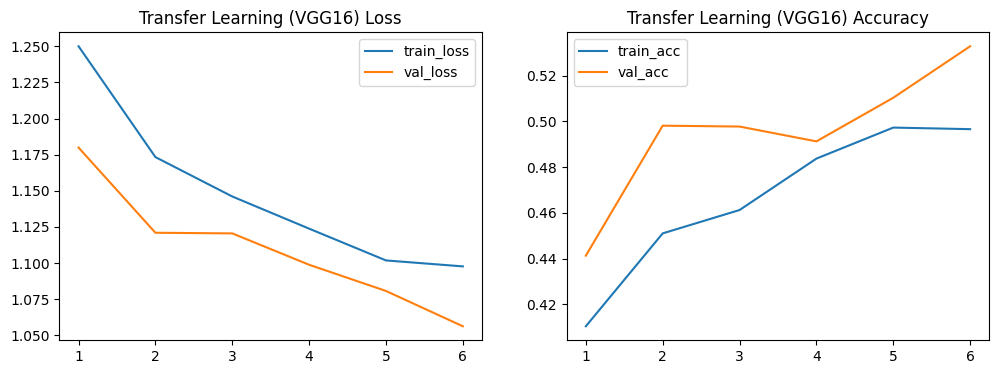

In [22]:
# Cell 11 — plot training history
def plot_history(h, title="History"):
    epochs = range(1, len(h['train_loss'])+1)
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(epochs, h['train_loss'], label='train_loss')
    plt.plot(epochs, h['val_loss'], label='val_loss')
    plt.title(title + " Loss"); plt.legend()
    plt.subplot(1,2,2)
    plt.plot(epochs, h['train_acc'], label='train_acc')
    plt.plot(epochs, h['val_acc'], label='val_acc')
    plt.title(title + " Accuracy"); plt.legend()
    plt.show()

print("Scratch history:")
plot_history(history_scratch, "Scratch CNN")
print("Transfer Learning history:")
plot_history(history_tl, "Transfer Learning (VGG16)")


# Single-image inference helper

Sample path: /kaggle/input/deepweeds/images/20171113-132154-3.jpg
{'pred': 2, 'prob': 0.40717586874961853, 'probs': array([0.00499809, 0.20510297, 0.40717587, 0.38133678, 0.0013862 ],
      dtype=float32)}


(np.float64(-0.5), np.float64(255.5), np.float64(255.5), np.float64(-0.5))

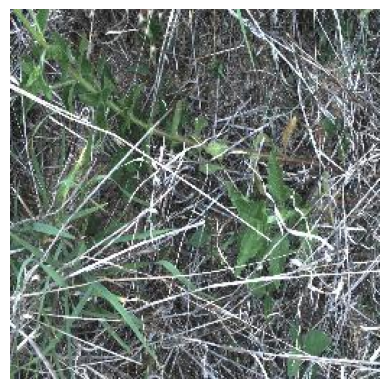

In [23]:
# Cell 13 — single-image prediction helper using transfer model
from PIL import Image
import numpy as np

def predict_image_tl(img_path, model, classes, device=DEVICE):
    model.eval()
    img = Image.open(img_path).convert('RGB')
    preprocess = transforms.Compose([
        transforms.Resize(int(IMG_SIZE*1.15)),
        transforms.CenterCrop(IMG_SIZE),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
    ])
    x = preprocess(img).unsqueeze(0).to(device)
    with torch.no_grad():
        out = model(x)
        prob = torch.softmax(out, dim=1)[0]
        idx = prob.argmax().item()
        return {"pred": classes[idx], "prob": float(prob[idx]), "probs": prob.cpu().numpy()}

# test on random test image
sample = random.choice(filepaths)
print("Sample path:", sample)
print(predict_image_tl(sample, model_tl, classes))
plt.imshow(plt.imread(sample)); plt.axis('off')


# Save models & class mapping

In [24]:
# Cell 14 — save models and class mapping
torch.save(model_scratch.state_dict(), "model_scratch_final.pt")
torch.save(model_tl.state_dict(), "model_tl_final.pt")
import json
with open("class_names.json", "w") as f:
    json.dump(classes, f)
print("Saved model_scratch_final.pt, model_tl_final.pt and class_names.json")


Saved model_scratch_final.pt, model_tl_final.pt and class_names.json


# Batch predict function (top-K)

In [25]:
# Cell A — batch predict top-K for a list or folder of images
from PIL import Image
import torch
import numpy as np
from torchvision import transforms
from pathlib import Path
import pandas as pd

def batch_predict(img_paths, model, classes, device=DEVICE, img_size=IMG_SIZE, topk=3):
    """
    img_paths: list of file paths (strings) or a folder path
    model: PyTorch model (already loaded on device)
    classes: list of class names (index -> name)
    returns: list of dicts {path, topk_preds: [(class,prob),...]}
    """
    model.eval()
    # allow passing a directory
    if isinstance(img_paths, (str, Path)) and Path(img_paths).is_dir():
        folder = Path(img_paths)
        img_paths = [str(p) for p in folder.rglob("*.*") if p.suffix.lower() in [".jpg",".jpeg",".png"]]
    elif isinstance(img_paths, (str, Path)):
        img_paths = [str(img_paths)]
    # preprocess
    preprocess = transforms.Compose([
        transforms.Resize(int(img_size*1.15)),
        transforms.CenterCrop(img_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
    ])
    results = []
    batch = []
    batch_paths = []
    BATCH_SZ = 16  # prediction batch size (adjust for memory)
    with torch.no_grad():
        for i, p in enumerate(img_paths):
            try:
                img = Image.open(p).convert("RGB")
            except Exception as e:
                print(f"Skipping {p}: {e}")
                continue
            t = preprocess(img)
            batch.append(t)
            batch_paths.append(p)
            # run a mini-batch
            if len(batch) == BATCH_SZ or i == len(img_paths)-1:
                x = torch.stack(batch).to(device)
                out = model(x)
                probs = torch.softmax(out, dim=1).cpu().numpy()
                for j, path in enumerate(batch_paths):
                    prob_vec = probs[j]
                    top_idxs = prob_vec.argsort()[-topk:][::-1]
                    top_preds = [(classes[idx], float(prob_vec[idx])) for idx in top_idxs]
                    results.append({"path": path, "topk": top_preds})
                batch = []; batch_paths = []
    return results

# Example usage (list of specific images)
example_paths = [
    # replace with your own paths or use some from test set, e.g.:
    str(filepaths[0]), str(filepaths[10]), str(filepaths[50])
]
res = batch_predict(example_paths, model_tl, classes, device=DEVICE, img_size=IMG_SIZE, topk=3)
res[:3]


[{'path': '/kaggle/input/deepweeds/images/20171219-112552-3.jpg',
  'topk': [(1, 0.4508945345878601),
   (2, 0.3902947008609772),
   (3, 0.14911764860153198)]},
 {'path': '/kaggle/input/deepweeds/images/20171218-120504-2.jpg',
  'topk': [(3, 0.44750556349754333),
   (2, 0.35653355717658997),
   (1, 0.17352117598056793)]},
 {'path': '/kaggle/input/deepweeds/images/20171212-095946-1.jpg',
  'topk': [(1, 0.5226536989212036),
   (2, 0.2526274025440216),
   (3, 0.21287931501865387)]}]

# Display results in a grid and save CSV

Saved predictions to batch_predictions.csv


,path,pred_1,conf_1,pred_2,conf_2,pred_3,conf_3
0,/kaggle/input/deepweeds/images/20171219-112552...,1,0.450895,2,0.390295,3,0.149118
1,/kaggle/input/deepweeds/images/20171218-120504...,3,0.447506,2,0.356534,1,0.173521
2,/kaggle/input/deepweeds/images/20171212-095946...,1,0.522654,2,0.252627,3,0.212879


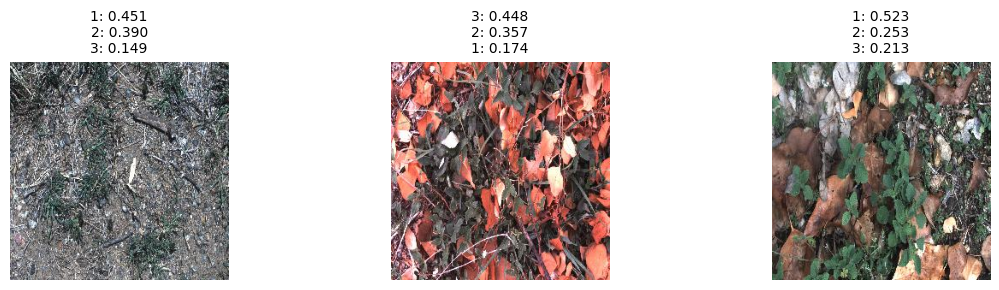

In [26]:
# Cell B — display results and save to CSV
import matplotlib.pyplot as plt
from math import ceil
import pandas as pd

def show_predictions(results, cols=3, save_csv="predictions.csv"):
    n = len(results)
    rows = ceil(n / cols)
    plt.figure(figsize=(4*cols, 3*rows))
    records = []
    for i, r in enumerate(results):
        path = r['path']
        topk = r['topk']
        title = "\n".join([f"{c}: {p:.3f}" for c,p in topk])
        try:
            img = plt.imread(path)
        except Exception:
            img = None
        ax = plt.subplot(rows, cols, i+1)
        if img is not None:
            plt.imshow(img)
            plt.axis('off')
        else:
            plt.text(0.5, 0.5, "Image\nnot\nreadable", ha='center', va='center')
            plt.axis('off')
        ax.set_title(title, fontsize=10)
        records.append({
            "path": path,
            "pred_1": topk[0][0], "conf_1": topk[0][1],
            "pred_2": topk[1][0] if len(topk) > 1 else None, "conf_2": topk[1][1] if len(topk) > 1 else None,
            "pred_3": topk[2][0] if len(topk) > 2 else None, "conf_3": topk[2][1] if len(topk) > 2 else None,
        })
    plt.tight_layout()
    # save CSV
    df_out = pd.DataFrame.from_records(records)
    df_out.to_csv(save_csv, index=False)
    print(f"Saved predictions to {save_csv}")
    return df_out

# Example: show and save the batch predictions we made earlier
df_preds = show_predictions(res, cols=3, save_csv="batch_predictions.csv")
df_preds.head()
